In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

In [2]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
# f_true = 0.534
from bioscrape.types import Model
from bioscrape.simulator import py_simulate_model

species = ['y']
parameters = {'m':m_true, 'b': b_true}
rule = ('assignment',{'equation':'y = _m*t + _b'})
x0 = {'y':0}
M = Model(species = species, parameters = parameters, rules = [rule], initial_condition_dict = x0)


#Simulate the Model deterministically
x0 = np.linspace(0, 10, 50)
results_det = py_simulate_model(x0, Model = M) #Returns a Pandas DataFrame


## Generate artificial data 

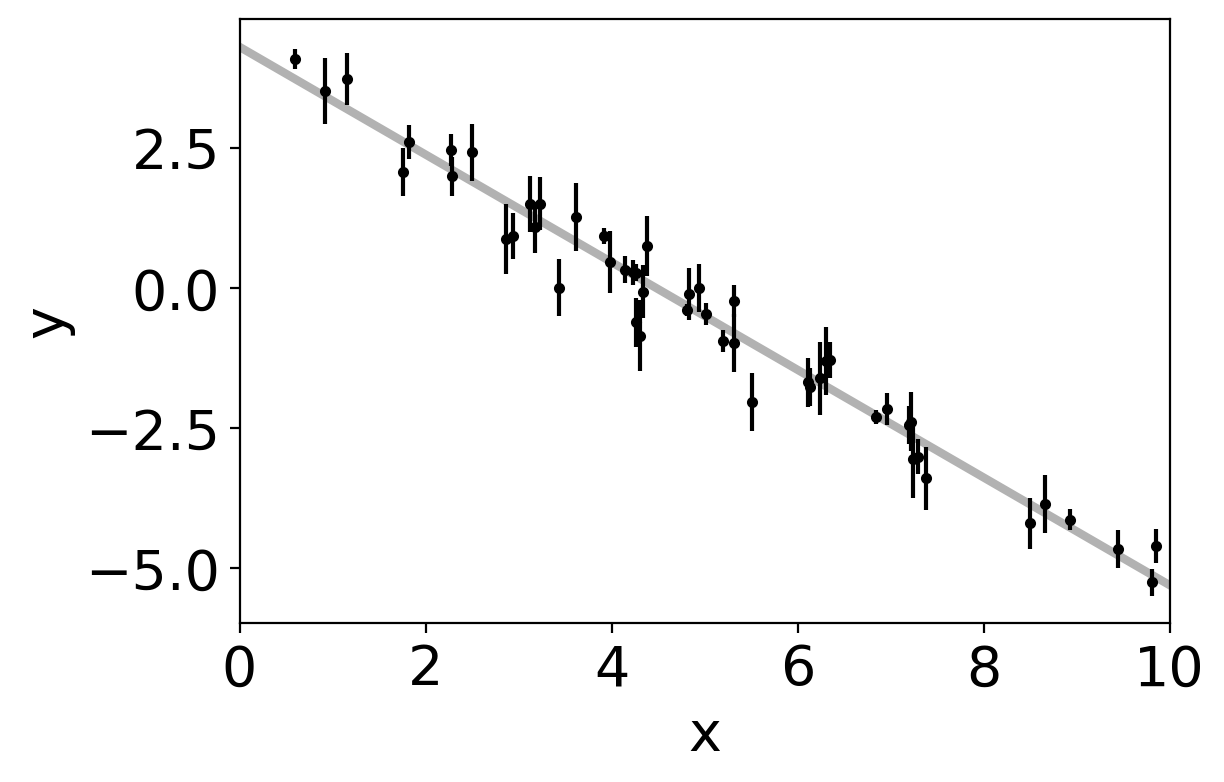

In [3]:

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.6 * np.random.rand(N)
y = m_true * x + b_true
# y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 50)
plt.plot(x0, results_det['y'], "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel('x')
plt.ylabel('y');

## Create Pandas dataframes as required by bioscrape inference

In [4]:
import pandas as pd
exp_data = pd.DataFrame()
exp_data['x'] = x0
exp_data['y'] = y
exp_data

,x,y
0,0.000000,4.081221
1,0.204082,3.508320
2,0.408163,3.715964
3,0.612245,2.069505
4,0.816327,2.598509
5,1.020408,2.450301
6,1.224490,1.986717
7,1.428571,2.415742
8,1.632653,0.870627
9,1.836735,0.922192


## Using bioscrape inference

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 340.20it/s]


Successfully completed MCMC parameter identification procedure. Parameter distribution data written to mcmc_results.csv file
Parameter posterior distribution convergence plots:


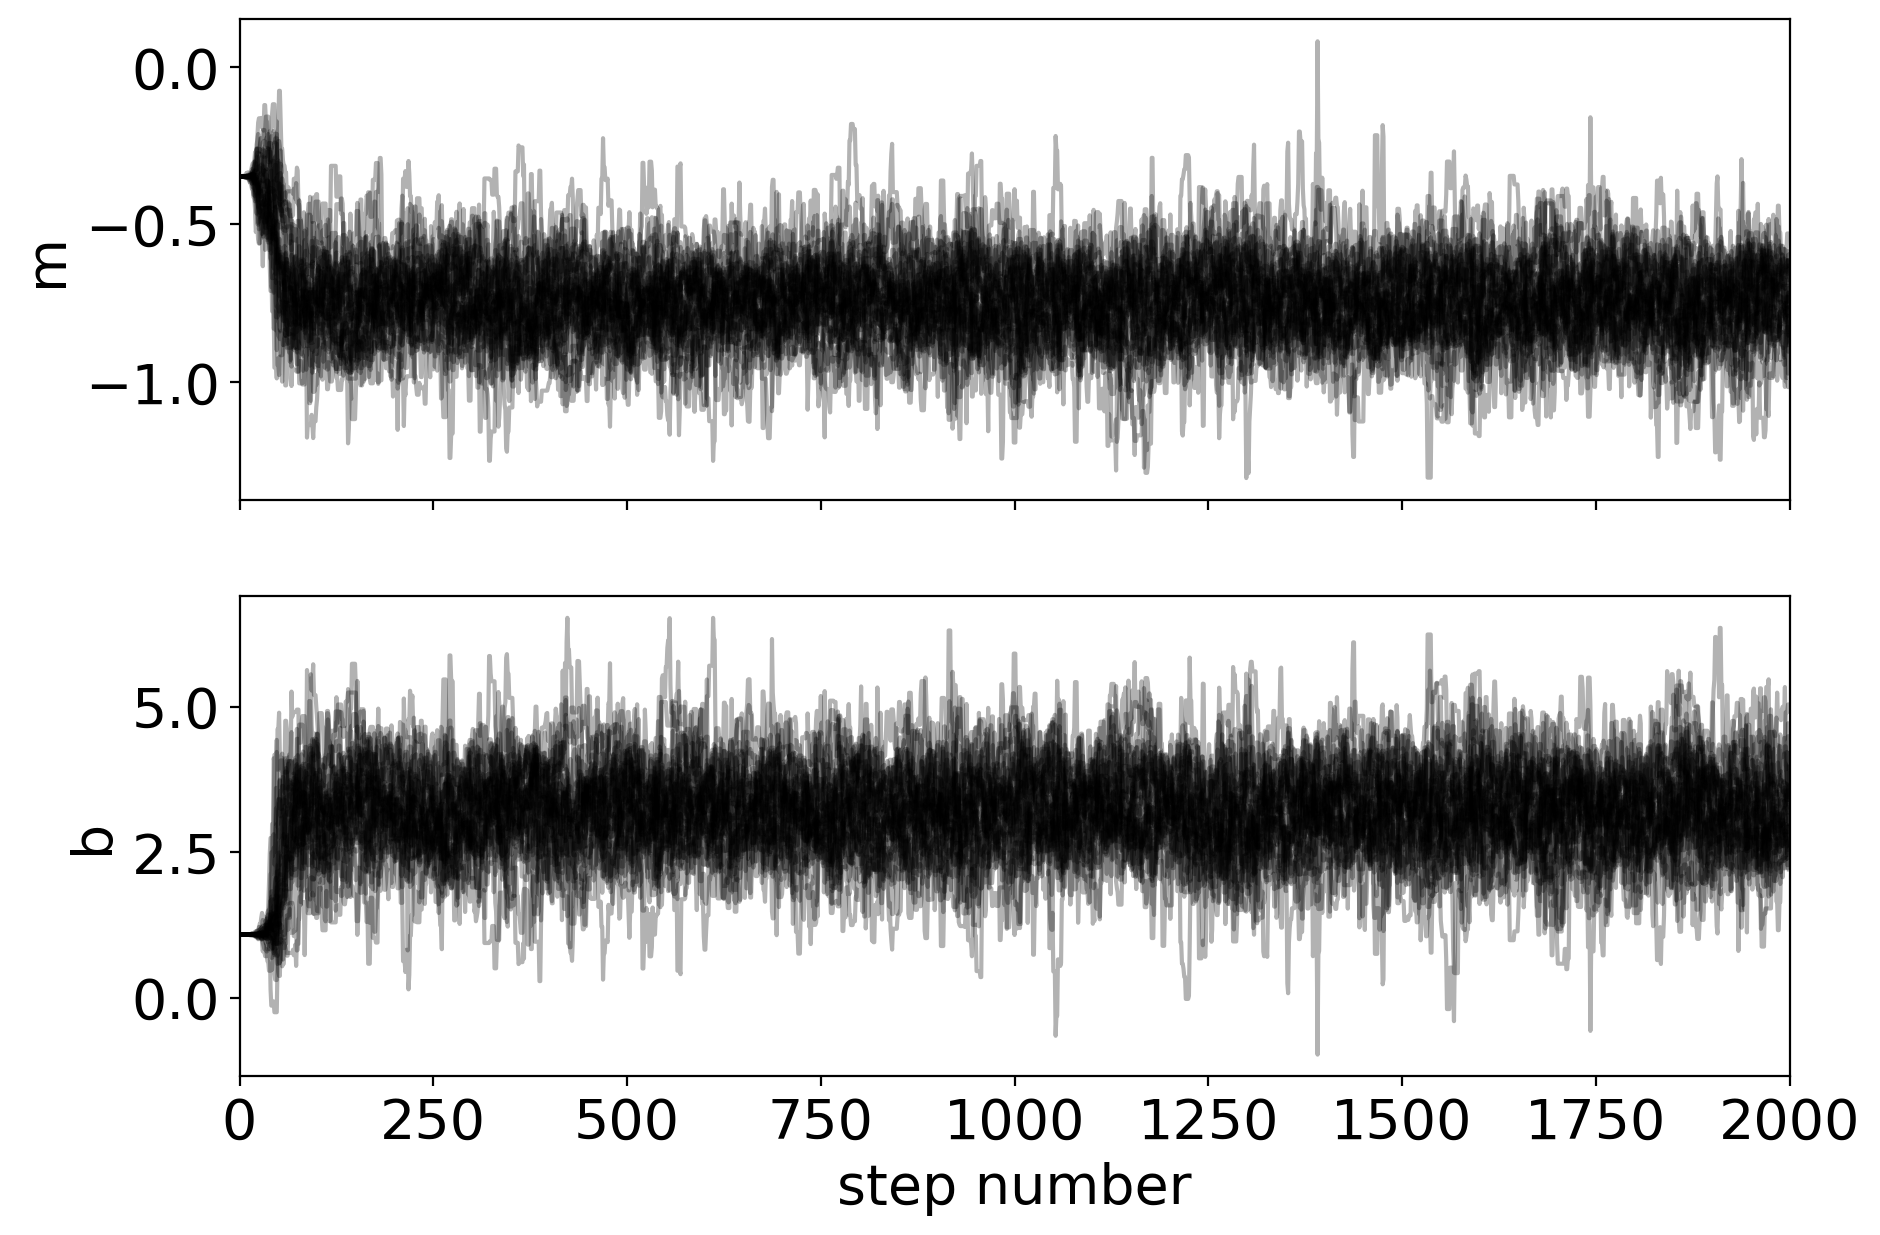

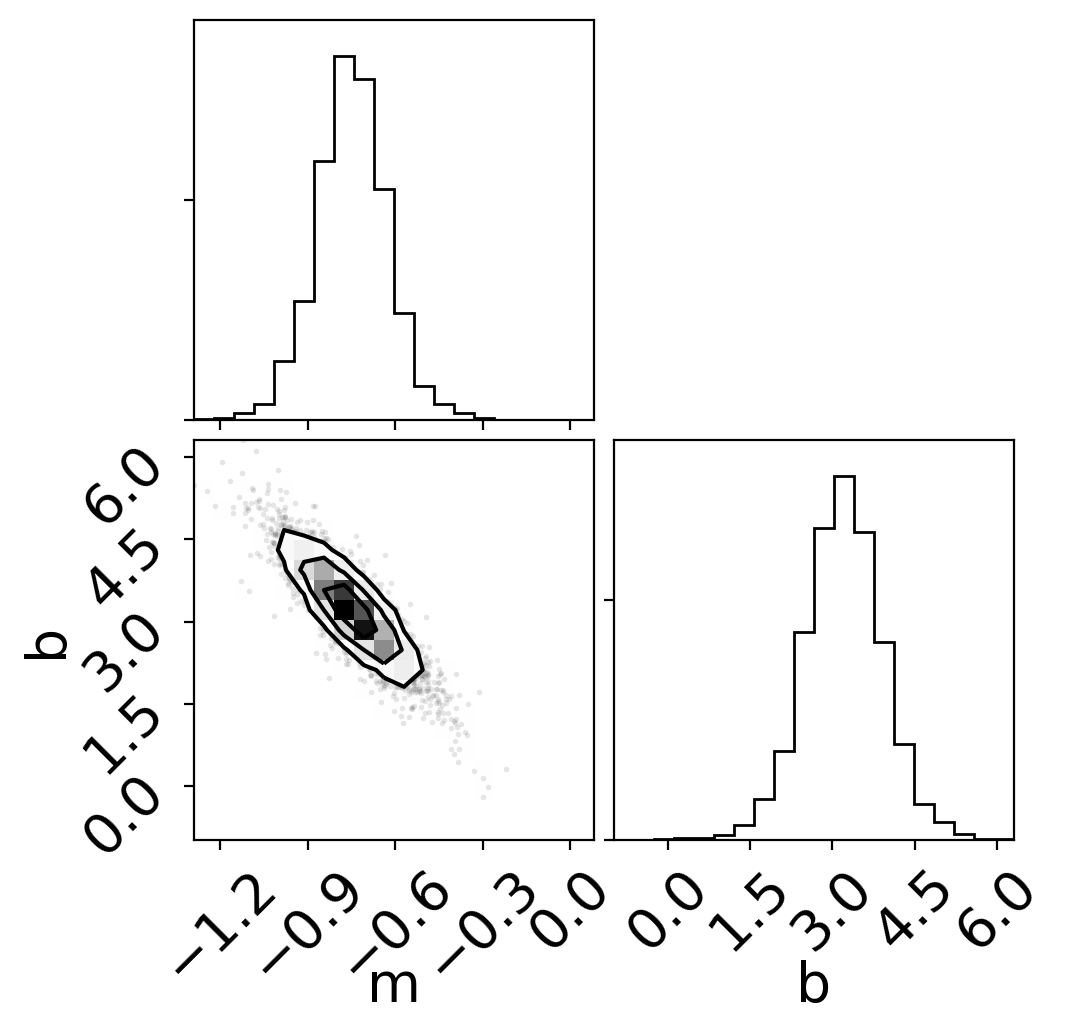

In [7]:
# from bioscrape.pid_interfaces import 
from bioscrape.inference import py_inference

# Import data from CSV
# Import a CSV file for each experiment run
prior = {'m' : ['gaussian', m_true, 500],'b' : ['gaussian', b_true, 1000]}
sampler, pid = py_inference(Model = M, exp_data = exp_data, measurements = ['y'],
                     time_column = ['x'], params_to_estimate = ['m', 'b'],
                      nwalkers = 32, nsteps = 2000, init_seed = 1e-4, prior = prior,
                      sim_type = 'deterministic', plot_show = False, convergence_check = True)

# Recommended to simply use sampler object/mcmc_results.csv and generate your own custom plots
truth_list, uncertainty_list = pid.plot_mcmc_results(sampler);

## Model simulations using parameter samples from the posterior distribution compared along side original model simulation

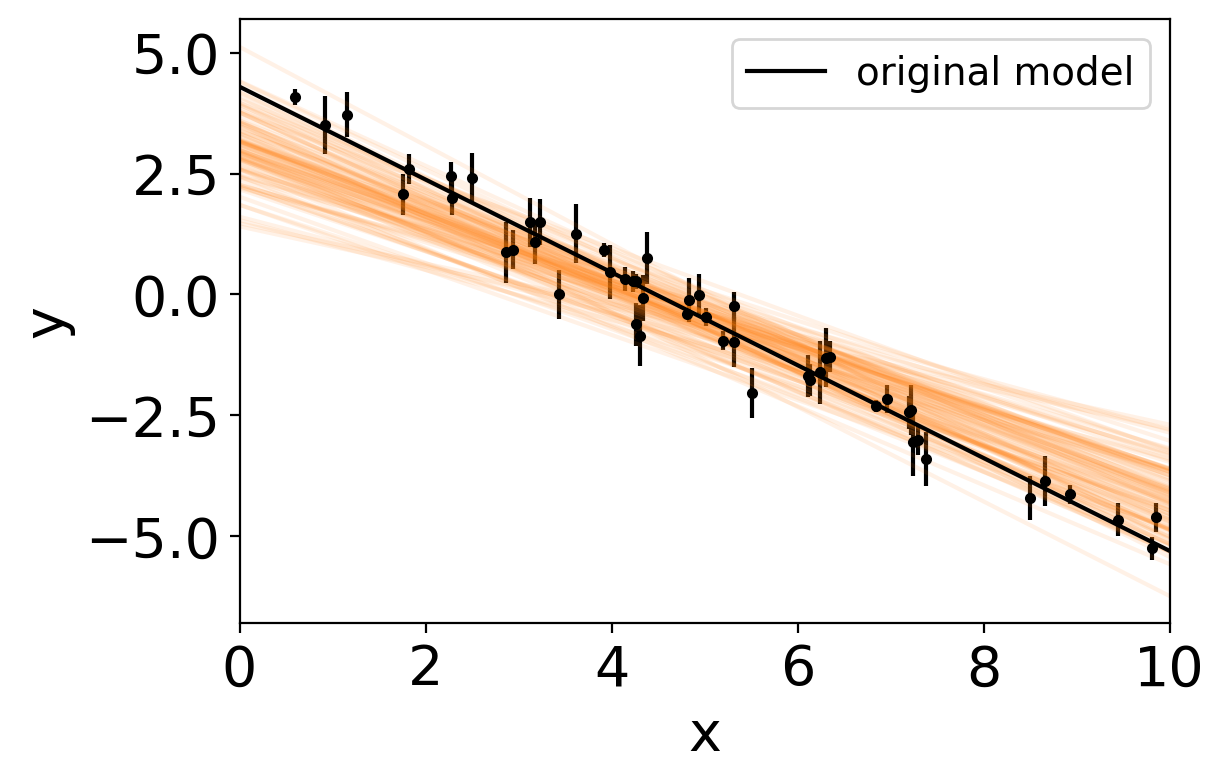

In [8]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", label="original model")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

# Other helpful utilities:
* Cost progress plots: You can look at the exploration of the log-likelihood by plotting cost_progress attribute of the inference object.
* The `plot_mcmc_results` returns the uncertainties around parameter values - this could indicate the accuracy of parameter inference predictions.
* You can use autocorrelation_time attribute of your inference object (pid.autocorrelation_time in the above example) to look at the autocorrelation time that it took for the chain to converge. A rule of thumb is that this value should be atleast 50 times lesser than the total number of steps for which you ran the MCMC chain. Higher autocorrelation time indicates that the chain was ended before it could converge to a distribution, whereas very low autocorrelation times could also be potentially something to look out for as it would indicate independence of all samples irrespective of the data.
* Check out Python emcee documentation on [**how to parallelize**](https://emcee.readthedocs.io/en/stable/tutorials/parallel/) the package using multiple CPU/GPU cores. 

In [ ]:
# rcParams['agg.path.chunksize'] = 10000
plt.close()
plt.figure()
plt.plot(pid.cost_progress)
plt.title('Log-likelihood progress')
plt.ylabel('Normed log-likelihood')
plt.xlabel('Number of steps in all chains')
plt.show()

In [ ]:
pid.autocorrelation_time